# Graph Neural Network

From Networks to Deep Learning


**Switching to deep learning**
- The growth lab https://growthlab.cid.harvard.edu/

- When we talk about the reality with mathematics or physics models, we are trying to reduce the complexity. Thus, we lose our understanding about the rich resolution.
- When there are clear-cut patterns, building up models could be a good idea. Or else, it may fail easily.


**Graph Attention Networks**

- pygat https://github.com/Diego999/pyGAT

**Graph Convolutional Network**

- pygcn https://github.com/tkipf/pygcn

# Convolutional Neural Network

<img src = 'cnn.png' width = '400'>
http://petar-v.com/GAT/

<img src = 'cnn2.png' width = '700'>

# Deepwalk
 
- uses local information obtained from **truncated random walks** 
    - to learn latent representations by 
- treating walks as the equivalent of sentences.
- Using word2vec method

DeepWalk: Online Learning of Social Representations. KDD2014 http://www.perozzi.net/projects/deepwalk/

# Node2vec

- it provides a way of balancing the exploration-exploitation tradeoff that in turn 
- leads to representations obeying a spectrum of equivalences from homophily to structural equivalence.

<img src = 'walk.png' width = '300'>

http://snap.stanford.edu/node2vec/

# Graph Convolutional Network

- $X$ is a matrix of node feature vectors.
- $A$ is an adjacent matrix.

$y  \sim f(X, A)$

Consider a multi-layer Graph Convolutional Network (GCN) with the following layer-wise propagation rule:

<img src = 'gcn.png' width = '700'>

https://github.com/tkipf/pygcn

** The Cora dataset**
- www.research.whizbang.com/data
- consists of Machine Learning papers. These papers are classified into one of the following seven classes:
Case_Based
Genetic_Algorithms
Neural_Networks
Probabilistic_Methods
Reinforcement_Learning
Rule_Learning
Theory
- citation network 
- There are 2708 papers in the whole corpus. 
- a vocabulary of size 1433 unique words. 
    - All words with document frequency less than 10 were removed.
- The .content file contains descriptions of the papers in the following format:

		<paper_id> <word_attributes>+ <class_label>

- The .cites file contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>


<img src = 'gcn2.png' width = '700'>
https://arxiv.org/pdf/1609.02907.pdf

In [1]:
#import pygcn
from __future__ import division
from __future__ import print_function

import time
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from pygcn.utils import load_data, accuracy
from pygcn.models import GCN

In [31]:
torch.__version__

'1.0.0'

In [4]:
class Args:
    def __init__(self):
        self.no_cuda = True
        self.fastmode = False
        self.seed = 42
        self.epochs = 200
        self.lr = 0.01
        self.weight_decay = 5e-4
        self.hidden = 16
        self.dropout = 0.5
        self.cuda = False
        
args = Args()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [3]:
ls

GAT.ipynb  cnn.png    cnn2.png   gcn.png    gcn2.png   pygat/     walk.png


In [32]:
# Load data
path = '/Users/datalab/github/deeplearning-winter2019/pygcn-master/data/cora/'
adj, features, labels, idx_train, idx_val, idx_test = load_data(path = path)

Loading cora dataset...


In [46]:
adj.shape, features.shape, labels.shape, idx_train.shape, idx_val.shape, idx_test.shape

(torch.Size([2708, 2708]),
 torch.Size([2708, 1433]),
 torch.Size([2708]),
 torch.Size([140]),
 torch.Size([300]),
 torch.Size([1000]))

In [47]:
from collections import Counter

Counter(features[0].data.numpy()), Counter(labels.data.numpy())

(Counter({0.0: 1413, 0.05: 20}),
 Counter({0: 180, 1: 298, 2: 418, 3: 426, 4: 818, 5: 351, 6: 217}))

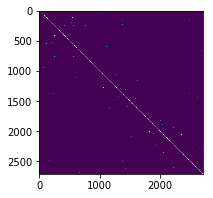

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize = [3, 3])
plt.imshow(adj.to_dense())
plt.show()

In [20]:
features.shape[1], args.hidden, labels.max().item() + 1, 

(1433, 16, 7)

In [16]:
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

In [60]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


In [61]:
import scipy.sparse as sp


path = '/Users/datalab/github/deeplearning-winter2019/pygcn-master/data/cora/'
dataset = 'cora'
"""Load citation network dataset (cora only for now)"""
print('Loading {} dataset...'.format(dataset))

idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                    dtype=np.dtype(str))
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
labels = encode_onehot(idx_features_labels[:, -1])

# build graph
idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                dtype=np.int32)
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                 dtype=np.int32).reshape(edges_unordered.shape)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))

idx_train = range(140)
idx_val = range(200, 500)
idx_test = range(500, 1500)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)


Loading cora dataset...


In [62]:
edges

array([[ 163,  402],
       [ 163,  659],
       [ 163, 1696],
       ...,
       [1887, 2258],
       [1902, 1887],
       [ 837, 1686]], dtype=int32)

In [77]:
edges = np.array([[ 1,  0],
       [ 0,  2],
       [ 1, 2]])

adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(3, 3),
                    dtype=np.float32)
print(adj.toarray(), '\n 1st')

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
print(adj.toarray(), '\n 2nd')

adj = normalize(adj + sp.eye(adj.shape[0]))
print(adj.toarray(), '\n 3rd')

[[0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 0.]] 
 1st
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]] 
 2nd
[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]] 
 3rd


In [71]:
adj.toarray()

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [54]:
from torch.nn.parameter import Parameter

Parameter(torch.FloatTensor(3, 4))

Parameter containing:
tensor([[ 0.0000e+00, -8.5899e+09, -5.5325e+16, -3.6902e+19],
        [ 5.9704e-33,  1.4013e-45,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7551e-40]],
       requires_grad=True)

In [17]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()


Epoch: 0001 loss_train: 1.9452 acc_train: 0.1143 loss_val: 1.9303 acc_val: 0.1067 time: 0.0365s
Epoch: 0002 loss_train: 1.9365 acc_train: 0.1214 loss_val: 1.9173 acc_val: 0.1033 time: 0.0243s
Epoch: 0003 loss_train: 1.9299 acc_train: 0.1429 loss_val: 1.9047 acc_val: 0.3467 time: 0.0222s
Epoch: 0004 loss_train: 1.9153 acc_train: 0.2643 loss_val: 1.8925 acc_val: 0.3500 time: 0.0218s
Epoch: 0005 loss_train: 1.9009 acc_train: 0.2857 loss_val: 1.8807 acc_val: 0.3500 time: 0.0199s
Epoch: 0006 loss_train: 1.8823 acc_train: 0.3000 loss_val: 1.8693 acc_val: 0.3500 time: 0.0198s
Epoch: 0007 loss_train: 1.8764 acc_train: 0.2929 loss_val: 1.8585 acc_val: 0.3500 time: 0.0198s
Epoch: 0008 loss_train: 1.8630 acc_train: 0.2929 loss_val: 1.8482 acc_val: 0.3500 time: 0.0220s
Epoch: 0009 loss_train: 1.8544 acc_train: 0.2929 loss_val: 1.8382 acc_val: 0.3500 time: 0.0219s
Epoch: 0010 loss_train: 1.8489 acc_train: 0.2929 loss_val: 1.8286 acc_val: 0.3500 time: 0.0190s
Epoch: 0011 loss_train: 1.8329 acc_train

Epoch: 0093 loss_train: 0.8302 acc_train: 0.8357 loss_val: 1.0411 acc_val: 0.7533 time: 0.0233s
Epoch: 0094 loss_train: 0.8731 acc_train: 0.8000 loss_val: 1.0311 acc_val: 0.7567 time: 0.0242s
Epoch: 0095 loss_train: 0.8644 acc_train: 0.8214 loss_val: 1.0211 acc_val: 0.7600 time: 0.0249s
Epoch: 0096 loss_train: 0.8513 acc_train: 0.8071 loss_val: 1.0110 acc_val: 0.7600 time: 0.0244s
Epoch: 0097 loss_train: 0.8201 acc_train: 0.8429 loss_val: 1.0009 acc_val: 0.7567 time: 0.0217s
Epoch: 0098 loss_train: 0.8056 acc_train: 0.8357 loss_val: 0.9914 acc_val: 0.7567 time: 0.0240s
Epoch: 0099 loss_train: 0.7770 acc_train: 0.8643 loss_val: 0.9829 acc_val: 0.7600 time: 0.0230s
Epoch: 0100 loss_train: 0.8201 acc_train: 0.8214 loss_val: 0.9747 acc_val: 0.7633 time: 0.0221s
Epoch: 0101 loss_train: 0.8101 acc_train: 0.8000 loss_val: 0.9667 acc_val: 0.7733 time: 0.0235s
Epoch: 0102 loss_train: 0.7146 acc_train: 0.8429 loss_val: 0.9591 acc_val: 0.7800 time: 0.0217s
Epoch: 0103 loss_train: 0.7087 acc_train

Epoch: 0186 loss_train: 0.4254 acc_train: 0.9429 loss_val: 0.6985 acc_val: 0.8067 time: 0.0195s
Epoch: 0187 loss_train: 0.4422 acc_train: 0.9214 loss_val: 0.6971 acc_val: 0.8100 time: 0.0226s
Epoch: 0188 loss_train: 0.4553 acc_train: 0.9429 loss_val: 0.6976 acc_val: 0.8100 time: 0.0218s
Epoch: 0189 loss_train: 0.4115 acc_train: 0.9286 loss_val: 0.6977 acc_val: 0.8067 time: 0.0208s
Epoch: 0190 loss_train: 0.3801 acc_train: 0.9357 loss_val: 0.6986 acc_val: 0.8067 time: 0.0192s
Epoch: 0191 loss_train: 0.4230 acc_train: 0.9286 loss_val: 0.6985 acc_val: 0.8067 time: 0.0190s
Epoch: 0192 loss_train: 0.4388 acc_train: 0.9143 loss_val: 0.6984 acc_val: 0.8100 time: 0.0180s
Epoch: 0193 loss_train: 0.4165 acc_train: 0.9286 loss_val: 0.6962 acc_val: 0.8133 time: 0.0211s
Epoch: 0194 loss_train: 0.3903 acc_train: 0.9214 loss_val: 0.6929 acc_val: 0.8167 time: 0.0205s
Epoch: 0195 loss_train: 0.4177 acc_train: 0.9357 loss_val: 0.6900 acc_val: 0.8167 time: 0.0198s
Epoch: 0196 loss_train: 0.3756 acc_train

In [5]:
import pygat

In [4]:
ls

GAT.ipynb  cnn.png    cnn2.png   gcn.png    gcn2.png   pygat/     walk.png


In [4]:
ls data/cora/

README*       cora.cites*   cora.content*


# Graph Attention Network

Consider a graph of **n** nodes
- node features: $(\vec{h}_1, \vec{h}_2, \dots, \vec{h}_n)$
- adjacency matrix $A$

To get a higher-level representation of node features

$\vec{g}_i = {\bf W}\vec{h}_i$

http://petar-v.com/GAT/

Define a graph convolutional operator as an aggregation of features across neighbourhoods. 
- The output features of node $i$  

$$\vec{h}'_i = \sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\vec{g}_j\right)$$

- $\sigma$ is an activation function, e.g., softmax
- $a_{ij}$ specifies the weighting factor (importance) of node j’s features to node i.

Let $a_{ij}$ be implicitly defined
- employing **self-attention** over the node features to do so, $a : \mathbb{R}^N \times \mathbb{R}^N \rightarrow \mathbb{R}$

$$e_{ij} = a(\vec{h}_i, \vec{h}_j)$$

- Normalised using the softmax function:

$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k\in\mathcal{N}_i}\exp(e_{ik})}$$

**Regularisation**
- To stabilise the learning process of self-attention
$$\vec{h}'_i = {\LARGE \|}_{k=1}^K \sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}^k{\bf W}^k\vec{h}_j\right)$$

where 
- ∥ represents concatenation
- $K$ denotes the number of independent attention mechanisms

<img src = './attention.png' width = '700'>
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.

- Every neighbour **i** of node sends its own vector of attentional coefficients, 
    - $\vec{\alpha}_{1i}$ one per each attention head $\alpha_{1i}^k$
- To compute **K** separate linear combinations of neighbours’ features  $\vec{h}_i$
- Aggregate (typically by concatenation or averaging) to obtain the next-level features of node $\vec{h}’_1$


In [102]:
ls

LICENSE*            data/               output/             utils.py*
README.md*          layers.py*          requirements.txt*   visualize_graph.py*
__pycache__/        models.py*          train.py*


In [85]:
cd pygat

/Users/datalab/github/deeplearning-winter2019/pyGAT-master/pygat


In [80]:
import os
import glob
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [87]:
from utils import load_data, accuracy
from models import GAT, SpGAT

In [120]:
class Args:
    def __init__(self):
        self.no_cuda=True
        self.cuda=False
        self.fastmode=False
        self.sparse=False
        self.seed=72
        self.epochs=2
        self.lr=5e-3
        self.weight_decay=5e-4
        self.hidden=8
        self.nb_heads=8
        self.dropout=0.6
        self.alpha=0.2
        self.patience=100
        
args = Args()

In [92]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()


Loading cora dataset...


In [100]:
# Model and optimizer
if args.sparse:
    model = SpGAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
else:
    model = GAT(nfeat=features.shape[1], 
                nhid=args.hidden, 
                nclass=int(labels.max()) + 1, 
                dropout=args.dropout, 
                nheads=args.nb_heads, 
                alpha=args.alpha)
    
optimizer = optim.Adam(model.parameters(), 
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

In [123]:
int(labels.max()) + 1

7

In [94]:
if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

features, adj, labels = Variable(features), Variable(adj), Variable(labels)

In [121]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.item()


def compute_test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = 0
for epoch in range(args.epochs):
    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

# Testing
compute_test()


Epoch: 0001 loss_train: 1.6168 acc_train: 0.5071 loss_val: 1.6278 acc_val: 0.5767 time: 31.6586s
Epoch: 0002 loss_train: 1.5773 acc_train: 0.5714 loss_val: 1.6154 acc_val: 0.5767 time: 30.0393s
Optimization Finished!
Total time elapsed: 62.3707s
Loading 1th epoch
Test set results: loss= 1.6820 accuracy= 0.4440


In [115]:
loss_train.item()

1.9512795209884644